In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch.nn.functional as F
import os
import scipy
import random
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader as DL
from torch.utils.data import TensorDataset as TData
from tqdm import tqdm
import re
from sklearn.model_selection import train_test_split as tts
import pickle

In [2]:
import os
from google.colab import drive
drive.mount('/content/drive')
root = '/content/drive/MyDrive/Colab Notebooks/LHNT/'
os.chdir(root)

Mounted at /content/drive


In [3]:
if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

In [ ]:
!unzip "LHNT_EEG.zip"

Archive:  LHNT_EEG.zip
   creating: LHNT EEG/
   creating: LHNT EEG/Nandini_Senthilkumar_Session6/
  inflating: LHNT EEG/Nandini_Senthilkumar_Session6/right_2.pkl  
  inflating: LHNT EEG/Nandini_Senthilkumar_Session6/right_20.pkl  
  inflating: LHNT EEG/Nandini_Senthilkumar_Session6/left_9.pkl  
  inflating: LHNT EEG/Nandini_Senthilkumar_Session6/left_1.pkl  
  inflating: LHNT EEG/Nandini_Senthilkumar_Session6/right_16.pkl  
  inflating: LHNT EEG/Nandini_Senthilkumar_Session6/left_7.pkl  
  inflating: LHNT EEG/Nandini_Senthilkumar_Session6/left_11.pkl  
  inflating: LHNT EEG/Nandini_Senthilkumar_Session6/right_14.pkl  
  inflating: LHNT EEG/Nandini_Senthilkumar_Session6/right_10.pkl  
  inflating: LHNT EEG/Nandini_Senthilkumar_Session6/right_4.pkl  
  inflating: LHNT EEG/Nandini_Senthilkumar_Session6/left_19.pkl  
  inflating: LHNT EEG/Nandini_Senthilkumar_Session6/left_3.pkl  
  inflating: LHNT EEG/Nandini_Senthilkumar_Session6/right_8.pkl  
  inflating: LHNT EEG/Nandini_Senthilkumar_

In [4]:
def getAllPickles(directory="LHNT EEG"):
    folders = [drctry for drctry in os.listdir(directory) if os.path.isdir(os.path.join(directory, drctry))]
    files = []
    for folder in folders:
        folder_files = os.listdir(os.path.join(directory, folder))
        for file in folder_files:
            if ".pkl" in file:
                files.append(os.path.join(directory, folder, file))
    return files

def npFromPickle(pickle_files):
    np_data = []
    labels = [] # 0 is left, 1 is right
    for file in pickle_files:
        with open(file, "rb") as f:
            data1 = pickle.load(f)
            np_data.append(data1[0])
        if 'right' in file.split('/')[-1]:
            labels.append(1)
        else:
            labels.append(0)
    return np_data, labels

np_data, labels = npFromPickle(getAllPickles())
print(len(np_data), len(labels))

380 380


In [5]:
# applying a bandpass filter
def bandpass_filter(signal, crit_freq = [1, 40], sampling_freq = 125, plot = False, channel = 0):
  order = 4

  b, a = scipy.signal.butter(order, crit_freq, btype = 'bandpass', fs = sampling_freq)
  processed_signal = scipy.signal.filtfilt(b, a, signal, 1)

  if plot == True:
    plt.figure()
    plt.xlabel('Time')
    plt.ylabel(f'Normalized amplitude of channel {channel}')
    plt.title(f'{crit_freq[0]}-{crit_freq[1]}Hz bandpass filter')
    signal_min = np.full((signal.shape[1], signal.shape[0]), np.min(signal, 1)).transpose()
    signal_max = np.full((signal.shape[1], signal.shape[0]), np.max(signal, 1)).transpose()
    normed_signal = (signal - signal_min) / (signal_max - signal_min)
    filtered_min = np.full((processed_signal.shape[1], processed_signal.shape[0]), np.min(processed_signal, 1)).transpose()
    filtered_max = np.full((processed_signal.shape[1], processed_signal.shape[0]), np.max(processed_signal, 1)).transpose()
    normed_filt = (processed_signal - filtered_min) / (filtered_max - filtered_min)
    plt.plot(np.arange(normed_signal[channel].size), normed_signal[channel], label = 'Input')
    plt.plot(np.arange(normed_filt[channel].size), normed_filt[channel], label = 'Transformed')
    plt.legend()

  return processed_signal


# function to segment eeg data based on sampling freq(Hz), window_size(s), and window_shift(s)
def segmentation(signal, sampling_freq=125, window_size=1, window_shift=0.016):
  w_size = int(sampling_freq * window_size)
  w_shift = int(sampling_freq * window_shift)
  segments = []
  i = 0
  while i + w_size <= signal.shape[1]:
    segments.append(signal[:, i: i + w_size])
    i += w_shift
  return segments

def channel_rearrangment(sig, channel_order):
    channel_order = [channel - 1 for channel in channel_order]
    reindexed = np.zeros_like(sig)
    for i, ind in enumerate(channel_order):
        reindexed[i] = sig[ind]
    return reindexed

ordered_channels = [1, 9, 11, 3, 2, 12, 10, 4, 13, 5, 15, 7, 14, 16, 6, 8]

In [6]:
train_x, test_x, train_y, test_y = tts(np_data, labels, test_size = 0.25)
val_x, test_x = test_x[:len(test_x)//2], test_x[len(test_x)//2:]
val_y, test_y = test_y[:len(test_y)//2], test_y[len(test_y)//2:]

In [7]:
# applying all preprocessing steps to create train and test data
train_eeg = []
train_labels = []
valid_eeg = []
valid_labels = []
test_eeg = []
test_labels = []
for sig, label in zip(train_x, train_y):
  if sig.shape[1] == 0: # excluding empty sample elements
    #print(name)
    continue
  reindexed_signal = channel_rearrangment(sig, ordered_channels)
  filtered_sig = bandpass_filter(reindexed_signal, [5, 40], 125) # bandpass filter
  normed_sig = (filtered_sig - np.mean(filtered_sig, 1, keepdims=True)) / np.std(filtered_sig, 1, keepdims=True) # standard scaling
  if np.isnan(normed_sig).any(): # excluding sample elements with nans
    print("nan")
    continue
  signals = segmentation(normed_sig, 125, window_size = 1.5, window_shift = 0.0175) # segmentation
  labels = [label] * len(signals)
  train_eeg.extend(signals)
  train_labels.extend(labels)

for sig, label in zip(val_x, val_y):
  if sig.shape[1] == 0: # excluding empty sample elements
    #print(name)
    continue
  reindexed_signal = channel_rearrangment(sig, ordered_channels)
  filtered_sig = bandpass_filter(reindexed_signal, [5, 40], 125) # bandpass filter
  normed_sig = (filtered_sig - np.mean(filtered_sig, 1, keepdims=True)) / np.std(filtered_sig, 1, keepdims=True) # standard scaling
  if np.isnan(normed_sig).any(): # excluding sample elements with nans
    print("nan")
    continue
  signals = segmentation(normed_sig, 125, window_size = 1.5, window_shift = 0.0175) # segmentation
  labels = [label] * len(signals)
  valid_eeg.extend(signals)
  valid_labels.extend(labels)

for sig, label in zip(test_x, test_y):
  if sig.shape[1] == 0: # excluding empty sample elements
    #print(name)
    continue
  reindexed_signal = channel_rearrangment(sig, ordered_channels)
  filtered_sig = bandpass_filter(reindexed_signal, [5, 40], 125) # bandpass filter
  normed_sig = (filtered_sig - np.mean(filtered_sig, 1, keepdims=True)) / np.std(filtered_sig, 1, keepdims=True) # standard scaling
  if np.isnan(normed_sig).any(): # excluding sample elements with nans
    print("nan")
    continue
  signals = segmentation(normed_sig, 125, window_size = 1.5, window_shift = 0.0175) # segmentation, changed to 125
  labels = [label] * len(signals)
  test_eeg.extend(signals)
  test_labels.extend(labels)

In [8]:
train_eeg_tensor = torch.zeros((len(train_eeg), train_eeg[0].shape[0], train_eeg[0].shape[1])) # untransposed dimensions 1 and 2
valid_eeg_tensor = torch.zeros((len(valid_eeg), valid_eeg[0].shape[0], valid_eeg[0].shape[1]))
test_eeg_tensor = torch.zeros((len(test_eeg), test_eeg[0].shape[0], test_eeg[0].shape[1]))
for i in range(len(train_eeg)):
  tens = torch.from_numpy(train_eeg[i].copy()) # no longer transposing before conversion to tensor
  train_eeg_tensor[i] = tens
for i in range(len(valid_eeg)):
  tens = torch.from_numpy(valid_eeg[i].copy())
  valid_eeg_tensor[i] = tens
for i in range(len(test_eeg)):
  tens = torch.from_numpy(test_eeg[i].copy())
  test_eeg_tensor[i] = tens
train_label_tensor = torch.zeros(len(train_labels), 2)
valid_label_tensor = torch.zeros(len(valid_labels), 2)
test_label_tensor = torch.zeros(len(test_labels), 2)
for i, val in enumerate(train_labels):
  train_label_tensor[i][val] = 1
for i, val in enumerate(valid_labels):
  valid_label_tensor[i][val] = 1
for i, val in enumerate(test_labels):
  test_label_tensor[i][val] = 1

train_ds = TData(train_eeg_tensor, train_label_tensor)
valid_ds = TData(valid_eeg_tensor, valid_label_tensor)
test_ds = TData(test_eeg_tensor, test_label_tensor)
train_dl = DL(train_ds, batch_size=64, shuffle= True, drop_last = True)
valid_dl = DL(valid_ds, batch_size=64, shuffle= True, drop_last = True)
test_dl = DL(test_ds, batch_size=64, shuffle = True, drop_last = True)

In [9]:
print(len(train_dl), len(valid_dl), len(test_dl))

1700 321 299


In [16]:
class AttentionModel(torch.nn.Module):
    def __init__(self, in_channels, n_classes):
        super().__init__()
        self.convblock1 = torch.nn.Sequential(torch.nn.Conv1d(in_channels, 16, kernel_size=3),
                                             torch.nn.Conv1d(16, 32, kernel_size=3),
                                            #  torch.nn.MaxPool1d(2),
                                             torch.nn.BatchNorm1d(32),
                                             torch.nn.ReLU(),
                                             )
        self.convblock2 = torch.nn.Sequential(torch.nn.Conv1d(32, 32, kernel_size=5),
                                              # torch.nn.Conv1d(48, 48, kernel_size=5),
                                              torch.nn.BatchNorm1d(32),
                                              torch.nn.MaxPool1d(2),
                                              torch.nn.ReLU(),
                                              )

        self.self_attention = torch.nn.MultiheadAttention(embed_dim=32, num_heads=2, batch_first=True)

        self.flatten = torch.nn.Flatten()
        self.dropout1 = torch.nn.Dropout(0.33)
        self.dropout2 = torch.nn.Dropout(0.25)

        self.fc1 = torch.nn.Sequential(torch.nn.Linear(2848, 128), torch.nn.ReLU())
        self.fc2 = torch.nn.Linear(128, n_classes)
    def forward(self, x):
        y = self.convblock1(x)
        # print("after conv1:", y.shape)
        y = self.convblock2(y)
        # print("after conv2:", y.shape)
        # y = self.flatten(y)
        y = y.permute(0, 2, 1)
        y = self.self_attention(y, y, y)[0]
        y = y.permute(0, 2, 1)
        # print("after attention:", y.shape)
        y = self.flatten(y)
        y = self.dropout1(y)
        y = self.fc1(y)
        y = self.dropout2(y)
        y = self.fc2(y)

        return y

convNet = AttentionModel(16, 2).to(device)

In [19]:
del convNet # only use when you want to delete and reinitialize the model

# Model training

In [13]:
print("Extracting model configuration...")
example_batch = next(iter(train_dl))
features, labels = example_batch
num_channels = features.shape[1]
sequence_length = features.shape[2]
num_classes = labels.shape[1]
print(f"Number of channels: {num_channels}")
print(f"Sequence length: {sequence_length}")
print(f"Number of classes: {num_classes}")
# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
# model = FCResCNN(num_channels, sequence_length, num_classes).to(device)
model = AttentionModel(num_channels, num_classes).to(device)
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
# Step 3: Training Function
def train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=20):
    print("Starting training...")
    for epoch in range(num_epochs):
        # start_time = time.time()
        model.train()
        train_loss = 0.0
        print(f"Epoch {epoch + 1}/{num_epochs}:")
        for batch_idx, (features, labels) in enumerate(train_loader):
            features, labels = features.to(device), labels.argmax(dim=1).to(device)
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if batch_idx % 10 == 0:  # Print every 10 batches
                print(f"  Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}")
        # Validation phase
        model.eval()
        valid_loss = 0.0
        with torch.no_grad():
            for features, labels in valid_loader:
                features, labels = features.to(device), labels.argmax(dim=1).to(device)
                outputs = model(features)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()
        # epoch_time = time.time() - start_time
        print(
            f"Train Loss: {train_loss / len(train_loader):.4f}, "
            f"Validation Loss: {valid_loss / len(valid_loader):.4f}"
        )
# Step 4: Evaluation Function
def evaluate_model(model, test_loader):
    print("Evaluating model on test data...")
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (features, labels) in enumerate(test_loader):
            features, labels = features.to(device), labels.argmax(dim=1).to(device)
            outputs = model(features)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            if batch_idx % 10 == 0:  # Print progress every 10 batches
                print(f"  Batch {batch_idx}/{len(test_loader)}, Running Accuracy: {100 * correct / total:.2f}%")
    accuracy = 100 * correct / total
    print(f"Final Test Accuracy: {accuracy:.2f}%")
# Step 5: Run Training and Evaluation
train_model(model, train_dl, valid_dl, criterion, optimizer, num_epochs=3)
evaluate_model(model, test_dl)

Extracting model configuration...
Number of channels: 16
Sequence length: 187
Number of classes: 2
Using device: cuda
Starting training...
Epoch 1/3:
  Batch 0/1700, Loss: 0.7049
  Batch 10/1700, Loss: 0.6889
  Batch 20/1700, Loss: 0.6893
  Batch 30/1700, Loss: 0.6942
  Batch 40/1700, Loss: 0.6894
  Batch 50/1700, Loss: 0.6928
  Batch 60/1700, Loss: 0.6924
  Batch 70/1700, Loss: 0.6919
  Batch 80/1700, Loss: 0.6954
  Batch 90/1700, Loss: 0.6916
  Batch 100/1700, Loss: 0.6941
  Batch 110/1700, Loss: 0.6932
  Batch 120/1700, Loss: 0.7010
  Batch 130/1700, Loss: 0.6867
  Batch 140/1700, Loss: 0.6839
  Batch 150/1700, Loss: 0.6999
  Batch 160/1700, Loss: 0.6898
  Batch 170/1700, Loss: 0.7023
  Batch 180/1700, Loss: 0.6984
  Batch 190/1700, Loss: 0.6919
  Batch 200/1700, Loss: 0.6826
  Batch 210/1700, Loss: 0.6852
  Batch 220/1700, Loss: 0.6898
  Batch 230/1700, Loss: 0.6932
  Batch 240/1700, Loss: 0.6871
  Batch 250/1700, Loss: 0.6598
  Batch 260/1700, Loss: 0.6826
  Batch 270/1700, Loss: 

KeyboardInterrupt: 

In [22]:
from tqdm.auto import tqdm
# using cross_entropy_loss
criterion = torch.nn.CrossEntropyLoss()
# using SGD optimizer for optimal convergence, even if slower
# optimizer = torch.optim.Adam(convNet.parameters(), lr = 1e-4)
# optimizer = torch.optim.SGD(convNet.parameters(), lr = 0.01, momentum = 0.9, weight_decay=0.01)
epochs = 5
patience = 1

train_losses = []
val_losses = []
best_val_loss = float('inf')
accs = []
max_acc = 0
patience_counter = 0
for i in range(epochs):
  total_train_loss = 0.0
  # set model to training mode
  convNet.train()
  # create progress bar
  pbar = tqdm(total=len(train_dl))
  for j, (sig, labels) in tqdm(enumerate(train_dl)):
    # add signal and label to cuda device
    sig = sig.to(device)
    labels = labels.argmax(dim=1).to(device)

    optimizer.zero_grad()
    # forward pass
    pred = convNet(sig)

    # loss evaluation
    loss = criterion(pred, labels)
    # backpropagation
    loss.backward()
    optimizer.step()

    total_train_loss += loss.item()
    # update progress bar with running loss
    pbar.set_description(f"Epoch {i + 1}    loss={total_train_loss / (j + 1):0.4f}")
    pbar.update(1)
  pbar.close()
  train_losses.append(total_train_loss / len(train_dl))

  total_val_loss = 0.0
  total_accuracy = 0.0
  # set model to evaluation mode, which changes the behavior
  # of some layers like dropout and batch normalization
  convNet.eval()
  with torch.no_grad():
      # create progress bar
      pbar = tqdm(total=len(valid_dl))
      for j, (sig, labels) in enumerate(valid_dl):
          # send signal and label to cuda device
          sig = sig.to(device)
          labels = labels.argmax(dim=1).to(device)
          # print(sig.shape)

          # make prediction and evaluate loss
          # labels = labels.to(torch.int64)
          pred = convNet(sig)
          loss = criterion(pred, labels)

          _, pred = torch.max(pred, 1)
          acc = (pred == labels).float().mean()

          # perform softmax on output which is usually performed by loss automatically
          # this gives a probability vector
          # prob_pred = torch.nn.functional.softmax(pred, -1)
          # compute accuracies by
          # 1. getting index of highest number (highest probability prediction)
          # 2. comparing the tensors element wise which gives boolean array comparing predictions to ground truth
          # 3. converting boolean array into array of 0s and 1s
          # 4. calculating mean with binary array, which gives (correct predictions) / (total predictions)
          # acc = (prob_pred.argmax(-1) == labels.argmax(-1)).float().mean()
          total_val_loss += loss.item()
          total_accuracy += acc.item()

          # update progress bar with val loss and accuracy
          pbar.set_description(f"val loss={total_val_loss / (j + 1):.4f}    val acc={total_accuracy / (j + 1):.4f}")
          pbar.update(1)
      print()
      pbar.close()
      val_losses.append(total_val_loss / len(valid_dl))
      accs.append(total_accuracy / len(valid_dl))
  if accs[-1] <= max_acc: # early stopping
    patience_counter += 1
    if patience_counter >= patience:
        print("Early stopping triggered!")
        break  # Exit the training loop
  else:
    # best_val_acc = accs[-1]
    patience_counter = 0

  # save model if accuracy is best seen
  if accs[-1] > max_acc:
    # dictionary with model state dict, optimizer state dict, and best accuracy
    checkpoint = {'state_dict': convNet.state_dict(), 'optimizer': optimizer.state_dict(), 'best_acc': accs[-1]}
    # save dictionary to specified file path if it exists or create new one otherwise
    torch.save(checkpoint, 'CNN-Attn_model.pth.tar')
    print('Model Saved')
    max_acc = accs[-1]

  0%|          | 0/1700 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/321 [00:00<?, ?it/s]


Model Saved


  0%|          | 0/1700 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/321 [00:00<?, ?it/s]


Model Saved


  0%|          | 0/1700 [00:00<?, ?it/s]

0it [00:00, ?it/s]

KeyboardInterrupt: 

# Model evaluation

In [24]:
# loading most accurate model
ckpt_dict = torch.load('CNN-Attn_model.pth.tar', weights_only=True)
convNet.load_state_dict(ckpt_dict['state_dict'])
# setting model to evaluation mode
convNet.eval()
test_accuracy = 0.0
test_loss = 0.0
with torch.no_grad():
      for signal, labels in test_dl:
          # send signal and label to cuda device
          signal = signal.to(device)
          labels = labels.to(device)
          # make prediction and evaluate loss

          pred = convNet(signal)
          loss = criterion(pred, labels)
          # compute probability vector and accuracy
          prob_pred = torch.nn.functional.softmax(pred, -1)
          acc = (prob_pred.argmax(-1) == labels.argmax(-1)).float().mean()
          test_loss += loss.item()
          test_accuracy += acc.item()

# display test set loss and accuracy
print(f'Test set    loss: {test_loss / len(test_dl):.4f}    accuracy: {test_accuracy / len(test_dl):.4f}')

Test set    loss: 0.8874    accuracy: 0.6150


Text(0, 0.5, 'cross entropy loss')

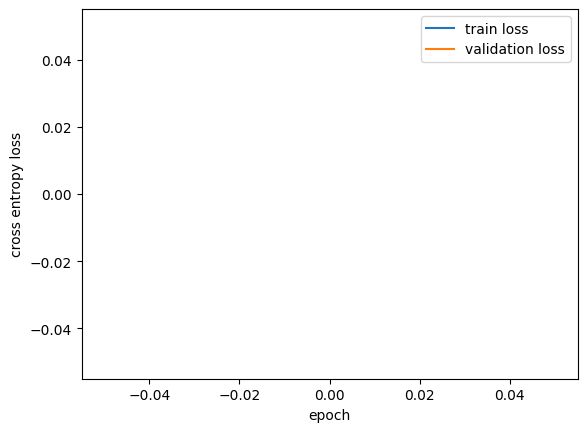

In [25]:
# plotting train and validation loss
plt.plot(train_losses, label = 'train loss')
plt.plot(val_losses, label = 'validation loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('cross entropy loss')

Text(0, 0.5, 'accuracy')

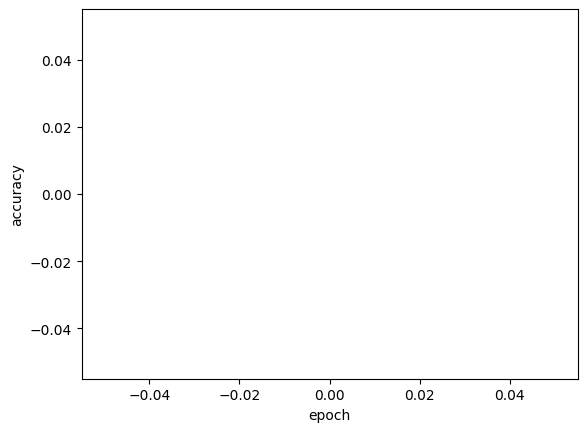

In [26]:
# plotting validation accuracy
plt.plot(accs)
plt.xlabel('epoch')
plt.ylabel('accuracy')